In [9]:
from openql import openql as ql
import qxelarator
from functools import reduce
import os
import matplotlib.pyplot as plt


In [10]:
nqubits = 3


In [11]:


def dice_compile():
    c = ql.Compiler("custom_compiler", "./compiler-config.json")

    platform = ql.Platform("myPlatform", "none")

    p = ql.Program("dice", platform, nqubits)
    k = ql.Kernel("aKernel", platform, nqubits)

    for q in range(nqubits):
        k.gate("h", [q])

    for q in range(nqubits):
        k.gate("measure", [q])

    p.add_kernel(k)
    c.compile(p)


dice_compile()


In [12]:
def plot_histogram(dice_faces):
    plt.hist(dice_faces, bins=8, color="#0504aa", alpha=0.7, rwidth=0.85)
    plt.grid(axis="y", alpha=0.75)
    plt.xlabel("Dice Face", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.title("Histogram", fontsize=15)
    plt.show()
    plt.savefig("hist.png")


In [17]:
def dice_execute_multishot():
    print("executing 8-face dice program on qxelarator")
    qx = qxelarator.QX()
    qx.set("./dice.custom.cq")
    dice_faces = []
    ntests = 100
    for _ in range(ntests):
        qx.execute()
        res = [int(qx.get_measurement_outcome(q)) for q in range(nqubits)]
        dice_face = reduce(lambda x, y: 2 * x + y, res, 0) + 1
        dice_faces.append(dice_face)

    return dice_faces


dice_faces = dice_execute_multishot()


executing 8-face dice program on qxelarator
[QXELERATOR]/__w/qx-simulator/qx-simulator/include/qx/simulator.h:91 Creating quantum register of 10 qubits... 
[QXELERATOR]/__w/qx-simulator/qx-simulator/include/qx/simulator.h:122 Loaded 2 circuits.
[+] executing circuit 'default' (1 iter) ...
[+] circuit execution time: 2e-07 sec.
[+] executing circuit 'aKernel' (1 iter) ...
[+] circuit execution time: 3.96e-05 sec.
[QXELERATOR]/__w/qx-simulator/qx-simulator/include/qx/simulator.h:91 Creating quantum register of 10 qubits... 
[QXELERATOR]/__w/qx-simulator/qx-simulator/include/qx/simulator.h:122 Loaded 2 circuits.
[+] executing circuit 'default' (1 iter) ...
[+] circuit execution time: 1e-07 sec.
[+] executing circuit 'aKernel' (1 iter) ...
[+] circuit execution time: 0.0017822 sec.
[QXELERATOR]/__w/qx-simulator/qx-simulator/include/qx/simulator.h:91 Creating quantum register of 10 qubits... 
[QXELERATOR]/__w/qx-simulator/qx-simulator/include/qx/simulator.h:122 Loaded 2 circuits.
[+] execut

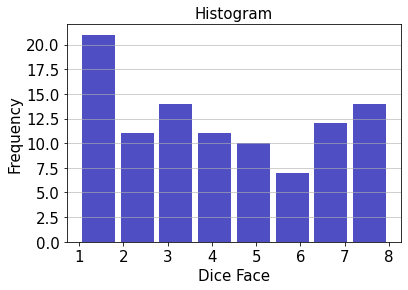

<Figure size 432x288 with 0 Axes>

In [18]:
plot_histogram(dice_faces)
